In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import librosa.display
from scipy.io import wavfile
from pydub import AudioSegment


In [77]:
folder = "./ArianaGrande"
file = "7rings"
mp3_to_wav (folder,file)

In [78]:
data, sr = librosa.load(folder+"/"+file+".wav")

In [79]:
# And compute the spectrogram magnitude and phase
idx1 = 115
idx2 = 125
y = data[idx1*sr:idx2*sr]
S_full, phase = librosa.magphase(librosa.stft(y))
# Play back a 5-second excerpt with vocals
Audio(y, rate=sr)

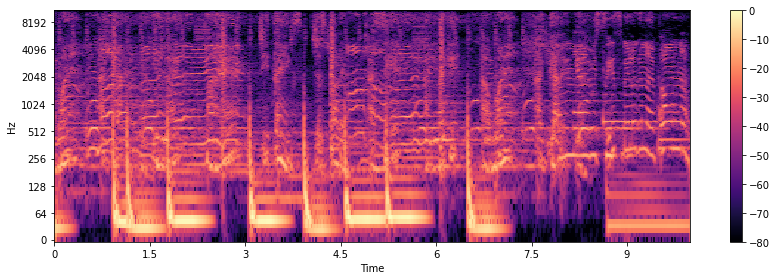

In [80]:
idx = slice(*librosa.time_to_frames([idx1, idx2], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, :], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [81]:
S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)
margin_i, margin_v = 2, 10
power = 3

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

In [82]:
y_foreground = librosa.istft(S_foreground * phase)
# Play back a 5-second excerpt with vocals
Audio(data=y_foreground, rate=sr)

In [83]:
y_foreground = librosa.istft(S_background * phase)
# Play back a 5-second excerpt with vocals
Audio(data=y_foreground, rate=sr)

In [84]:
y_combine = librosa.istft((S_foreground+S_background) * phase)
Audio(data=y_combine, rate=sr)

In [7]:
def mp3_to_wav (folder,file):
    sound = AudioSegment.from_mp3(folder+"/"+file+".mp3")
    sound.export(folder+"/"+file+".wav", format="wav")